In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats

import os, sys

project_root = '/user_data/mmhender/featsynth/'
sys.path.insert(0, os.path.join(project_root, 'code'))
from utils import stats_utils, plot_utils
from behav_analysis import analyze_expt1, analyze_expt2

#### load the image activations

In [2]:
image_set_name = 'images_expt2'

feat_path = os.path.join(project_root, 'features', 'simclr')
training_type='simclr'
feat_all = []

for ll in [2,6,12,15]:

    feat_file_name = os.path.join(feat_path, \
                                          '%s_%s_block%d_pca.npy'%(image_set_name,\
                                                                   training_type, \
                                                                   ll))
    print(feat_file_name)
    feat = np.load(feat_file_name)

    feat_all += [feat]

feat_all = np.concatenate(feat_all, axis=1)
feat = feat_all
feat = scipy.stats.zscore(feat, axis=0)
  
# load corresponding labels
image_list_filename = os.path.join(project_root, 'features','raw', '%s_list.csv'%(image_set_name))
labels = pd.read_csv(image_list_filename)

# figure out some image/category properties here
n_ims_each = np.sum(np.array(labels['basic_name'])==np.array(labels['basic_name'])[0])
basic_names = np.array(labels['basic_name'][0::n_ims_each])
super_names_long = np.array(labels['super_name'][0::n_ims_each])
basic_inds = np.array(labels['basic_index'][0::n_ims_each])
super_inds_long = np.array(labels['super_index'][0::n_ims_each])
n_basic = len(basic_names)
n_super = len(np.unique(super_names_long))
n_basic_each_super  = int(n_basic/n_super)
super_names = super_names_long[0::n_basic_each_super]
super_cbinds = np.repeat(np.array([0,1]), n_basic_each_super)
super_inds = np.arange(n_super)

# more image properties to organize images
image_type_names = ['pool1','pool2','pool3','pool4','orig']
n_image_types = len(image_type_names)
cue_level_names = ['basic','super']

/user_data/mmhender/featsynth/features/simclr/images_expt2_simclr_block2_pca.npy
/user_data/mmhender/featsynth/features/simclr/images_expt2_simclr_block6_pca.npy
/user_data/mmhender/featsynth/features/simclr/images_expt2_simclr_block12_pca.npy
/user_data/mmhender/featsynth/features/simclr/images_expt2_simclr_block15_pca.npy


#### compute basic-level separability

In [3]:
# within and across basic-categs
within_b = np.zeros((n_basic, n_image_types))
across_b_within_s = np.zeros((n_basic, n_image_types))
across_b_all = np.zeros((n_basic, n_image_types))

for ii, imtype in enumerate(image_type_names):

    for bi in range(n_basic):

        inds = (np.array(labels['basic_index'])==bi) & (np.array(labels['image_type'])==imtype)
        f1 = feat[inds,:]

        # comparing images from the same basic-level category
        d1 = scipy.spatial.distance.pdist(f1, metric='cosine')

        # average across all pairwise comparisons
        within_b[bi,ii] = np.mean(d1.ravel())

        # now find all images that are in same super-ordinate category but different basic-level
        si = super_inds_long[bi]
        inds2 = (labels['basic_index']!=bi) & (labels['super_index']==si)  & \
                (np.array(labels['image_type'])==imtype)

        f2 = feat[inds2,:]

        # comparing images from same superordinate, different basic-level
        d2 = scipy.spatial.distance.cdist(f1, f2, metric='cosine')

        # average over all pairwise comparisons
        across_b_within_s[bi,ii] = np.mean(d2.ravel())

        # find all images that are in any different basic-level (can be different super too)
        inds3 = (labels['basic_index']!=bi) & (np.array(labels['image_type'])==imtype)

        f3 = feat[inds3,:]

        # comparing images from same superordinate, different basic-level
        d3 = scipy.spatial.distance.cdist(f1, f3, metric='cosine')

        # average over all pairwise comparisons
        across_b_all[bi,ii] = np.mean(d3.ravel())



# get ratio of across to within
basic_sep = across_b_within_s / within_b 
basic_sep_all = across_b_all / within_b 
# basic_sep = ((across_b_within_s-within_b) / (across_b_within_s+within_b)) 

#### average across all the basic-level categs in each superordinate category

In [4]:
within_b_each_supcat = np.array([np.mean(within_b[super_inds_long==si,:], axis=0) \
                                for si in range(n_super)])
across_b_within_s_each_supcat = np.array([np.mean(across_b_within_s[super_inds_long==si,:], axis=0) \
                                for si in range(n_super)])
across_b_all_each_supcat = np.array([np.mean(across_b_all[super_inds_long==si,:], axis=0) \
                                for si in range(n_super)])


basic_sep_each_supcat = np.array([np.mean(basic_sep[super_inds_long==si,:], axis=0) \
                                   for si in range(n_super)])

basic_sep_all_each_supcat = np.array([np.mean(basic_sep_all[super_inds_long==si,:], axis=0) \
                                   for si in range(n_super)])

#### compute superordinate separability

In [5]:
n_samples = 10

within_s = np.zeros((n_super, n_image_types, n_samples))
across_s = np.zeros((n_super, n_image_types, n_samples))

# use the exemplar labels to sub-sample trials (match number available for basic-level)
sample_labels = np.mod(np.array(labels['exemplar_number']), 10)

for ii, imtype in enumerate(image_type_names):

    for si in range(n_super):

        for sa in range(n_samples):
                
            inds =  (np.array(labels['super_index'])==si)  & \
                    (np.array(labels['image_type'])==imtype) & \
                    (sample_labels==sa)
            
            f = feat[inds,:]
            # print(f.shape)
    
            # comparing images from the same super-level category
            d = scipy.spatial.distance.pdist(f, metric='cosine')
    
            # average across all pairwise comparisons
            within_s[si,ii,sa] = np.mean(d.ravel())
    
            # different superordinate categ, but same image set (groups of 10 super categ)
            inds2 = (np.array(labels['super_index'])!=si) & \
                    (super_cbinds[np.array(labels['super_index'])]==super_cbinds[si]) & \
                    (np.array(labels['image_type'])==imtype) & \
                    (sample_labels==sa)
    
            f2 = feat[inds2,:]
            # print(f2.shape)
    
            # comparing images from diff super-level
            d = scipy.spatial.distance.cdist(f, f2, metric='cosine')
    
            # average over all pairwise comparisons
            across_s[si,ii,sa] = np.mean(d.ravel())

within_s = np.mean(within_s, axis=2)
across_s = np.mean(across_s, axis=2)

# compute ratio of across / within
super_sep_each_supcat = across_s / within_s
# super_sep_each_supcat = ((across_s-within_s) / (across_s+within_s)) 

#### plot average separability of each type

(1.0, 1.04)

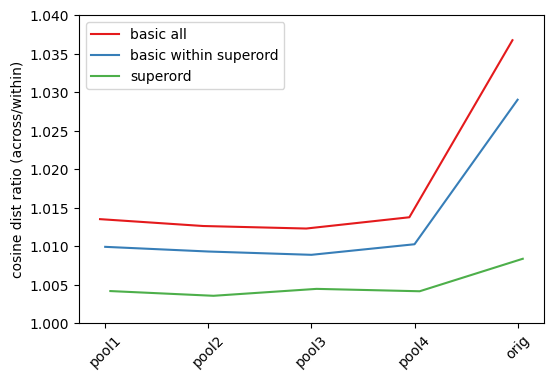

In [6]:
plot_utils.set_all_font_sizes(10)

xjitters =np.linspace(-0.05, 0.05, 3)

cue_level_colors = cm.Set1(np.linspace(0,1,9))[0:3,:]

point_types = ['o','x']
markersize = 4;


plt.figure(figsize=(6,4))

ax = plt.subplot(1,1,1)
    # lh = []

vals1 = np.mean(basic_sep_all, axis=0)
vals2 = np.mean(basic_sep, axis=0)
vals3 = np.mean(super_sep_each_supcat, axis=0)
levels = ['basic all','basic within superord','superord']

for cc, vals in enumerate([vals1, vals2, vals3]):

    h = plt.plot(np.arange(n_image_types)+xjitters[cc], vals,\
             '-',color=cue_level_colors[cc,:])

    # lh.append(h[0])

    plt.xticks(np.arange(n_image_types), image_type_names,rotation=45)


# plt.axhline(0, color=[0.8, 0.8, 0.8], linestyle='--')

# ax.legend(lh, np.repeat(cue_level_vals,2), loc='lower right')
ax.legend(levels, loc='upper left')

plt.ylabel('cosine dist ratio (across/within)')

plt.ylim([1.0, 1.04])



#### separate into natural and artificial superord categories

In [7]:
is_natural = np.array([1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1]).astype(bool)
kind_names = ['Artificial','Natural']
n_kinds = len(kind_names)
nat_colors = cm.Greens(np.linspace(0,1,5))[[2,3],:]

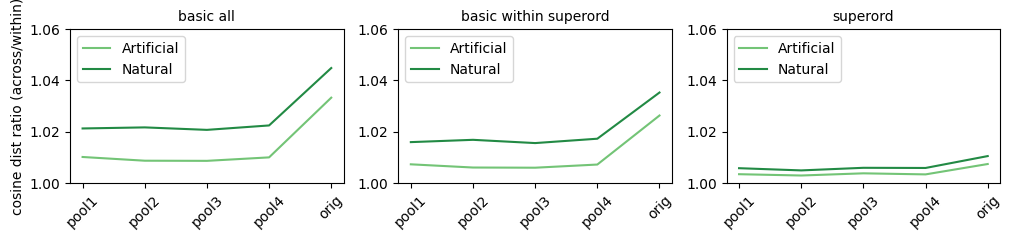

In [11]:
vals1 = np.mean(basic_sep_all, axis=0)
vals2 = np.mean(basic_sep, axis=0)
vals3 = np.mean(super_sep_each_supcat, axis=0)
levels = ['basic all','basic within superord','superord']

plt.figure(figsize=(12,2))
pi=0

for vals, level in zip([basic_sep_all_each_supcat, \
                        basic_sep_each_supcat, \
                        super_sep_each_supcat], \
                      levels):
        
    pi+=1
    ax = plt.subplot(1,3,pi)
    
    lh = []
    
    for kk in [0,1]:
    
        meanvals = np.mean(vals[is_natural==kk,:], axis=0)
    
        h = plt.plot(np.arange(n_image_types), meanvals, color=nat_colors[kk,:])
    
        lh += h
        
    ax.legend(lh, kind_names, loc='upper left');
    plt.xticks(np.arange(n_image_types), image_type_names, rotation=45);

    if pi==1:
        plt.ylabel('cosine dist ratio (across/within)')
    
    plt.ylim([1.0, 1.06])
    
    plt.title(level)

# plt.suptitle('grayscale')

In [11]:
plt.figure(figsize=(12,2))
pi=0

levels = ['within basic','within superord']
for vals, level in zip([within_b_each_supcat, 
                        within_s], \
                      levels):
        
    pi+=1
    ax = plt.subplot(1,3,pi)
    
    lh = []
    
    for kk in [0,1]:
    
        meanvals = np.mean(vals[is_natural==kk,:], axis=0)
    
        h = plt.plot(np.arange(n_image_types), meanvals, color=nat_colors[kk,:])
    
        lh += h
        
    ax.legend(lh, kind_names, loc='lower left');
    plt.xticks(np.arange(n_image_types), image_type_names, rotation=45);

    if pi==1:
        plt.ylabel('cosine dist')

    plt.ylim([0.94, 1.0])
    # plt.ylim([1.0, 1.06])
    
    plt.title(level)

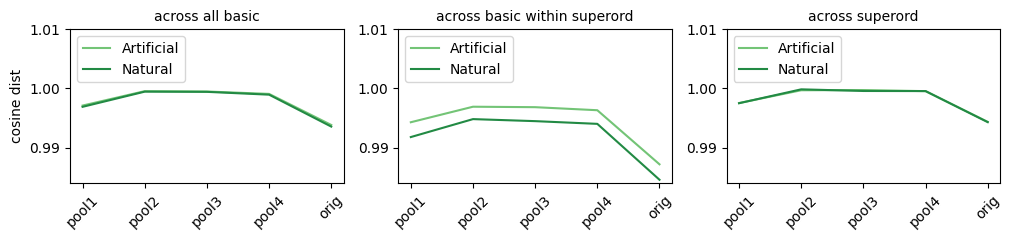

In [12]:
plt.figure(figsize=(12,2))
pi=0

levels = ['across all basic','across basic within superord', 'across superord']
for vals, level in zip([across_b_all_each_supcat,
                        across_b_within_s_each_supcat,
                        across_s], \
                      levels):
        
    pi+=1
    ax = plt.subplot(1,3,pi)
   
    lh = []
    
    for kk in [0,1]:
    
        meanvals = np.mean(vals[is_natural==kk,:], axis=0)
    
        h = plt.plot(np.arange(n_image_types), meanvals, color=nat_colors[kk,:])
    
        lh += h
        
    ax.legend(lh, kind_names, loc='upper left');
    plt.xticks(np.arange(n_image_types), image_type_names, rotation=45);

    if pi==1:
        plt.ylabel('cosine dist')

    plt.ylim([0.984, 1.01])
    # plt.ylim([1.0, 1.06])
    
    plt.title(level)

0.9943174177261523
0.0012373953440593035
0.9861091731966709
0.005121217151304303
0.9863863275734162
0.006650400856522353
0.9595059792415236
0.02927772887100776


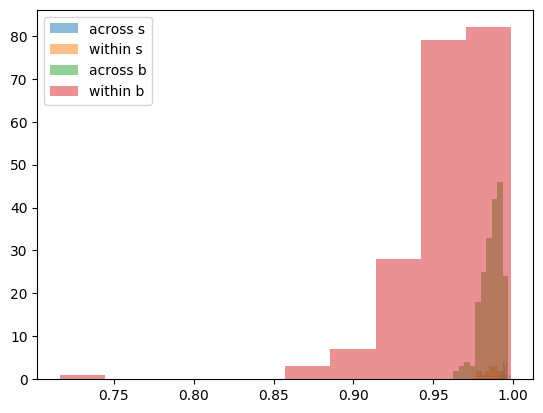

In [13]:
plt.figure()
ii = 4;
for vals in [across_s[:,ii], within_s[:,ii], across_b_within_s[:,ii], within_b[:,ii]]:

    print(np.mean(vals))
    print(np.std(vals))
    plt.hist(vals, alpha=0.5);

plt.legend(['across s','within s', 'across b', 'within b'])